In [243]:
# Modues to be used
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import plot_roc_curve

In [4]:
# Load data from pickle files

# -> Player dictionary with the dataFrames
f = open('../data/dict_player.pickle', 'rb')
dict_player = pickle.load(f)

# -> Map dataFrames
f = open('../data/df_map.pickle','rb')
df_map = pickle.load(f)

# -> Map dictionary
f = open('../data/dict_map.pickle','rb')
dict_map = pickle.load(f)

In [269]:
DAYS_WEIGHT = 365

time_1 = datetime.now()

# If we want matches only between only ranked teams
df_tmp = df_map[ (df_map['date']>datetime(2019,1,1)) &
    ( (df_map['team_rank_1']>0) & (df_map['team_rank_2']>0) ) ]



dict_train = {}

print( len( df_tmp['map_id']) )

#2000 -> ~4min
for map_id in df_tmp['map_id'][:]:

    map_date = df_tmp.loc[map_id]['date']

    dict_train[map_id] = {}    

    # Here we are taking the rankings to be non-zero
    rank_1 = df_tmp.loc[map_id]['team_rank_1']
    rank_2 = df_tmp.loc[map_id]['team_rank_2']

    winner = df_tmp.loc[map_id]['winner']

    if rank_1 < rank_2:
        fav = 0
        dict_train[map_id]['rank_dif'] = rank_2-rank_1

        if winner == 1:
            dict_train[map_id]['fav_win'] = 1
        else:
            dict_train[map_id]['fav_win'] = 0

    else:
        fav = 1
        dict_train[map_id]['rank_dif'] = rank_1-rank_2

        if winner == 2:
            dict_train[map_id]['fav_win'] = 1
        else:
            dict_train[map_id]['fav_win'] = 0

    count_team = -1
    for team_id in dict_map[map_id]:

        count_team = count_team + 1

        weighted_rating    = []
        # weighted_kast      = []
        # weighted_kpr       = []
        # weighted_round_dif = []

        prize = []

        for player_id in dict_map[map_id][team_id]['players_id']:            

            #df_aux = dict_player[player_id][ dict_player[player_id]['map']==map_name ]

            df_aux = dict_player[player_id]

            date_vec = (map_date-df_aux['date']).astype('timedelta64[D]')

            # date_vec = (map_date-dict_player[player_id]['date']).astype('timedelta64[D]')

            # df_op_rank = df_tmp[ df_tmp['team_rank_1'] ]

            # df_aux = dict_player[player_id][ (date_vec>1) & (date_vec<DAYS_WEIGHT)  ]

            #df_aux = dict_player[player_id][ (date_vec>1) & (date_vec<DAYS_WEIGHT) ]

            # df_aux = df_aux[ df_aux['map']==map_name ]

            df_aux = df_aux[ (date_vec>1) & (date_vec<DAYS_WEIGHT) ]

            try:
                m = float(1.0)/ sum( date_vec[(date_vec>1) & (date_vec<DAYS_WEIGHT)]-DAYS_WEIGHT )
            except:
                m = 0.0

            w_i = m * (date_vec[(date_vec>1) & (date_vec<DAYS_WEIGHT)] - DAYS_WEIGHT)
            
            weighted_rating.append( sum(df_aux['rating'] * w_i) )

            # weighted_kast.append( sum(df_aux['KAST'] * w_i / 100.0) )
            # weighted_kpr.append( sum(df_aux['kills_per_round'] * w_i) )
            

            # weighted_round_dif.append( sum( (df_aux['team_score']-df_aux['op_score']) * w_i) )

            prize.append( df_aux['prize'].sum() )

        order = np.argsort( weighted_rating )

        # if count_team == fav:
        #     count_p = -1
        #     for ind in order:
        #         count_p = count_p + 1
        #         dict_train[map_id]['t_0_p_'+str(count_p)+'_rating'] = weighted_rating[ind]
        #         dict_train[map_id]['t_0_p_'+str(count_p)+'_kast'] = weighted_rating[ind]
        #         dict_train[map_id]['t_0_p_'+str(count_p)+'_kpr'] = weighted_rating[ind]
        # else:
        #     count_p = -1
        #     for ind in order:
        #         count_p = count_p + 1
        #         dict_train[map_id]['t_1_p_'+str(count_p)+'_rating'] = weighted_rating[ind]
        #         dict_train[map_id]['t_1_p_'+str(count_p)+'_kast'] = weighted_rating[ind]
        #         dict_train[map_id]['t_1_p_'+str(count_p)+'_kpr'] = weighted_rating[ind]

        if count_team == fav:

            dict_train[map_id]['t0_prize'] = np.average( prize )

            dict_train[map_id]['t_0_avg_rating'] = np.average( weighted_rating )
            # dict_train[map_id]['t_0_std_rating'] = np.std( weighted_rating )

            # dict_train[map_id]['t_0_avg_kast'] = np.average( weighted_kast )
            # dict_train[map_id]['t_0_std_kast'] = np.std( weighted_kast )

            # dict_train[map_id]['t_0_avg_kpr'] = np.average( weighted_kpr )
            # dict_train[map_id]['t_0_std_kpr'] = np.std( weighted_kpr )

            # dict_train[map_id]['t_0_avg_rd'] = np.average( weighted_round_dif )
            # dict_train[map_id]['t_0_std_rd'] = np.std( weighted_round_dif )

        else:

            dict_train[map_id]['t1_prize'] = np.average( prize )

            dict_train[map_id]['t_1_avg_rating'] = np.average( weighted_rating )
            # dict_train[map_id]['t_1_std_rating'] = np.std( weighted_rating )

            # dict_train[map_id]['t_1_avg_kast'] = np.average( weighted_kast )
            # dict_train[map_id]['t_1_std_kast'] = np.std( weighted_kast )

            # dict_train[map_id]['t_1_avg_kpr'] = np.average( weighted_kpr )
            # dict_train[map_id]['t_1_std_kpr'] = np.std( weighted_kpr )

            # dict_train[map_id]['t_1_avg_rd'] = np.average( weighted_round_dif )
            # dict_train[map_id]['t_1_std_rd'] = np.std( weighted_round_dif )

    

time_2 = datetime.now()

print( time_2-time_1 )
#date_vec

10466
0:19:20.859490


# Here we process the results we got

In [270]:

df_train = pd.DataFrame.from_dict(dict_train,orient='index')

for map_id in df_train.index:
    df_train.at[map_id,'rating_dif'] = (dict_train[map_id]['t_0_avg_rating'] - dict_train[map_id]['t_1_avg_rating'])

    if dict_train[map_id]['t0_prize'] > 0:
        dict_train[map_id]['t0_prize_rating'] = np.log(dict_train[map_id]['t0_prize']) / 12.0
    else:
        dict_train[map_id]['t0_prize_rating'] = 0.0

    if dict_train[map_id]['t1_prize'] > 0:
        dict_train[map_id]['t1_prize_rating'] = np.log(dict_train[map_id]['t1_prize']) / 12.0
    else:
        dict_train[map_id]['t1_prize_rating'] = 0.0


    df_train.at[map_id,'prize_rating_dif'] = dict_train[map_id]['t0_prize_rating'] - dict_train[map_id]['t1_prize_rating'] 
    #df_train.at[map_id,'kast_dif'] = 1.0*(dict_train[map_id]['t_0_avg_kast'] - dict_train[map_id]['t_1_avg_kast'])**1
    #df_train.at[map_id,'rank_rating'] = df_train.at[map_id,'t_1_avg_rating'] / df_train.at[map_id,'rank_dif']


df_train = df_train.fillna(0)

print(df_train.keys())

df_train['fav_win'].mean()

Index(['rank_dif', 'fav_win', 't0_prize', 't_0_avg_rating', 't1_prize',
       't_1_avg_rating', 'rating_dif', 'prize_rating_dif'],
      dtype='object')


0.6120772023695776

In [271]:
df_train.head()

,rank_dif,fav_win,t0_prize,t_0_avg_rating,t1_prize,t_1_avg_rating,rating_dif,prize_rating_dif
79922,9,0,1304.666667,1.055806,3854.166667,1.079054,-0.023249,-0.090267
79923,9,0,1304.666667,1.055806,3854.166667,1.079054,-0.023249,-0.090267
79943,80,1,6333.333333,1.098823,1613.833333,1.081069,0.017754,0.113935
79945,80,0,6333.333333,1.098823,1613.833333,1.081069,0.017754,0.113935
79947,80,0,6333.333333,1.098823,1613.833333,1.081069,0.017754,0.113935


# Now the Logistic regression model

In [329]:
# Keep only the features that we want
df_tmp = df_train.drop(['rank_dif', 't0_prize', 't_0_avg_rating', 't1_prize',
         't_1_avg_rating'],axis=1)

#df_tmp = df_train.drop([ 't0_prize', 't1_prize'],axis=1)

# Drop nothing
#df_tmp = df_train.drop(['rank_dif','t0_prize', 't1_prize','rating_dif','prize_rating_dif','t_1_avg_rating'],axis=1)

# Divide data set into training and testing sets      
X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop(['fav_win'],axis=1),df_tmp['fav_win'], test_size=0.25)


#X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['fav_win','rank_dif'],axis=1),df_train['fav_win'], test_size=0.25)

#X_train, X_test, y_train, y_test = train_test_split(x_orig,y_orig, test_size=0.25)

# Make an instance of the model, and increase the maximum number of iterations to avoid convergence problems
logmodel = LogisticRegression(max_iter=800)

# Training for the model
logmodel.fit(X_train,y_train)

# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = logmodel.predict(X_test)

print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

#predictions[:] = 1

#c_mat = confusion_matrix(y_test.values, predictions)
c_mat = confusion_matrix(y_test, predictions)
print( c_mat )

accuracy = (c_mat[0][0] + c_mat[1][1]) / np.sum(c_mat)
print(accuracy)

y_scores = logmodel.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_scores)

>               precision    recall  f1-score   support

Underdog wins       0.61      0.18      0.27      1007
Favorite wins       0.64      0.93      0.76      1610

     accuracy                           0.64      2617
    macro avg       0.63      0.55      0.52      2617
 weighted avg       0.63      0.64      0.57      2617

[[ 177  830]
 [ 112 1498]]
0.6400458540313336


0.6443507250488815

In [255]:
filename = 'model_jan30.sav'
pickle.dump( logmodel, open(filename,'wb') )

In [256]:
df_tmp.head()

,fav_win,rating_dif,prize_rating_dif
79922,0,-0.023249,-0.090267
79923,0,-0.023249,-0.090267
79943,1,0.017754,0.113935
79945,0,0.017754,0.113935
79947,0,0.017754,0.113935


[[ 172  831]
 [ 125 1489]]
>               precision    recall  f1-score   support

Underdog wins       0.58      0.17      0.26      1003
Favorite wins       0.64      0.92      0.76      1614

     accuracy                           0.63      2617
    macro avg       0.61      0.55      0.51      2617
 weighted avg       0.62      0.63      0.57      2617



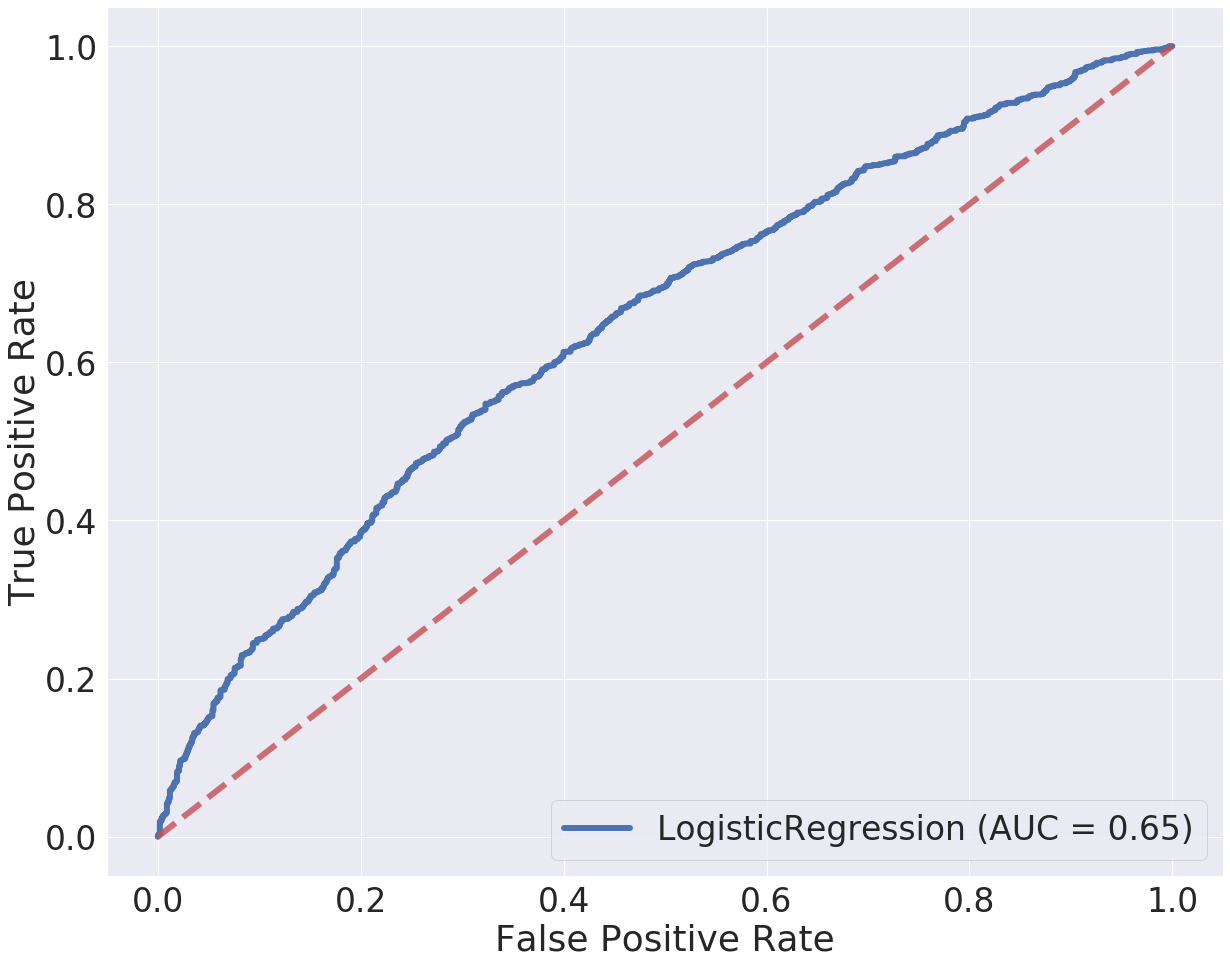

In [305]:
# Test with different tresholds
y_scores = logmodel.predict_proba(X_test)[:,1]
predictions = (y_scores > 0.5) *1
#print(predictions)

c_mat = confusion_matrix(y_test, predictions)
print( c_mat )

print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))
roc_auc_score(y_test, y_scores)

sns.set_style("whitegrid")
sns.set(font_scale=3)

plt.figure(figsize=(20,16));
ax = plt.axes()
plot_roc_curve(logmodel, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

ax.plot([0, 1], [0, 1], linestyle='--', lw=6, color='r',
        label='Chance', alpha=.8 )

plt.show()

In [64]:
print(y_scores)

[0.58217396 0.70538484 0.62385906 0.58364854 0.52852056 0.51313207
 0.57512057 0.56297732 0.68300915 0.51485599 0.59261334 0.54575573
 0.54091634 0.64784133 0.62040165 0.71631764 0.60675222 0.58767929
 0.55483196 0.53123342 0.9066794  0.50870046 0.6857333  0.58413612
 0.49861967 0.63555062 0.54262391 0.70538465 0.63859271 0.81966956
 0.49594607 0.51367837 0.56477698 0.54542274 0.52908915 0.66438087
 0.51218395 0.66114491 0.57925142 0.60436657 0.59966738 0.6165169
 0.53574472 0.6564637  0.81954772 0.73763471 0.51392463 0.71414087
 0.57559163 0.61344341 0.5400597  0.5251716  0.50435511 0.66852658
 0.54169512 0.52948996 0.89381201 0.71546403 0.6802322  0.58063817
 0.57885408 0.65613107 0.58641499 0.61588786 0.62632493 0.49560392
 0.50482653 0.58190807 0.59546567 0.67644279 0.60380139 0.5085201
 0.47253415 0.56453124 0.64380454 0.53619415 0.52169954 0.52856139
 0.52128307 0.53865538 0.76305929 0.96253808 0.54270941 0.53174004
 0.5059786  0.55870407 0.53262191 0.67448515 0.58495348 0.608070

In [200]:
logmodel.coef_

array([[4.32149969, 3.07989256]])